- 참조 

  - 텐서플로우 공식 홈페이지

# 딥드림(DeepDream)

- 합성곱 신경망이 학습한 표현을 사용하여 예술적으로 이미지를 조작하는 기법

- 구글이 카페(Caffe) 딥러닝 라이브러리를 사용하여 구현

- 딥드림에서는 특정 필터가 아니라 전체 층의 활성화를 최대화  
  한꺼번에 많은 특성을 섞어 시각화

- 빈 이미지나 노이즈가 조금 있는 입력이 아니라 이미 가지고 있는 이미지를 사용

- 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(옥타브, octave)로 처리

  <img src="https://www.tensorflow.org/tutorials/generative/images/dogception.png?hl=ko">

  <sub>[이미지 출처] https://www.tensorflow.org/tutorials/generative/deepdream?hl=ko</sub>

## 딥드림 구현

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/deepdream?hl=ko

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

### 이미지 선택

* https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [ ]:
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

def deprocess(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

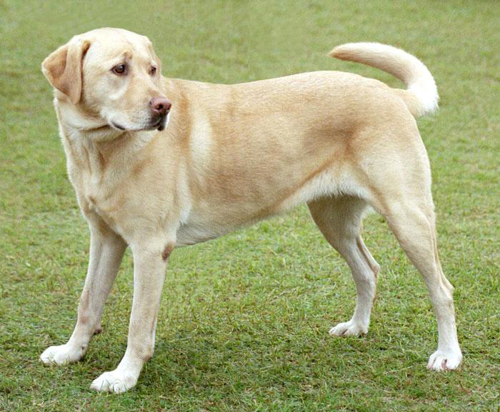

In [ ]:
original_img = download(url, max_dim=500)
show(original_img) 

### 사전 훈련된 인셉션 V3 모델 로드

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### 활성화할 레이어 선택
- 딥드림은 활성화시킬 하나 혹은 그 이상의 층을 선택한 후 "손실"을 최대화하도록 이미지를 수정함으로써 선택한 층을 "흥분"시키는 원리를 기반

- 얼마나 복잡한 특성이 나타날지는 선택한 층에 따라 다름

  - 낮은 층을 선택한다면 획 또는 간단한 패턴이 향상되고,  
    깊은 층을 선택한다면 이미지 내의 복잡한 패턴이나 심지어 물체의 모습도 생성할 수 있음

- 딥드림을 구현하기 위해 살펴보아야 할 곳은 합성곱층들이 연결된 부분

- InceptionV3에는 'mixed0'부터 'mixed10'까지 총 11개의 이러한 합성곱층이 존재

- 이 중 어떤 층을 선택하느냐에 따라서 딥드림 이미지의 모습이 결정

- 깊은 층은 눈이나 얼굴과 같은 고차원 특성(higher-level features)에 반응하는 반면,  
  낮은 층은 선분이나 모양, 질감과 같은 저차원 특성에 반응
  
- 임의의 층을 선택해 자유롭게 실험해보는 것도 가능  
  다만 깊은 층(인덱스가 높은 층)은 훈련을 위한 그래디언트 계산에 시간이 오래 걸릴 수 있음

In [ ]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### 손실 계산

- 손실은 선택한 층들의 활성화값의 총합으로 계산

- 층의 크기와 상관 없이 모든 활성화값이 동일하게 고려될 수 있도록 각 층의 손실을 정규화

- 일반적으로, 손실은 경사하강법으로 최소화하고자 하는 수치이지만,  
  딥드림에서는 예외적으로 이 손실을 경사상승법(gradient ascent)을 통해 최대화할 것

In [ ]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

### 모델 구성

- 선택한 층의 손실을 구했다면, 이제 남은 순서는 입력 이미지에 대한 그래디언트를 계산하여 원본 이미지에 추가하는 것

- 원본 이미지에 그래디언트를 더하는 것은 신경망이 보는 이미지 내의 패턴을 향상시키는 일에 해당

  - 훈련이 진행될수록 신경망에서 선택한 층을 더욱더 활성화시키는 이미지를 생성할 수 있음

- 성능을 최적화하기 위해 `tf.function`으로 만들고,  `input_signature`를 이용해 함수가 다른 이미지 크기 혹은 step/step_size값에 대해 트레이싱(tracing)되지 않도록 함

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
                       tf.TensorSpec(shape=[], dtype=tf.int32),
                       tf.TensorSpec(shape=[], dtype=tf.float32),)
  )

  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, self.model)

      gradients = tape.gradient(loss, img)

      gradients /= tf.math.reduce_std(gradients) + 1e-8 # 정규화 후 0이 안 되게 작은 값 더해줌

      img = img + gradients * step_size # 경사상승법(손실 최대화시켜 선택한 층 자극시킴)
      img = tf.clip_by_value(img, -1, 1)
      
    return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

### main loop

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)

    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step: {}, loss: {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

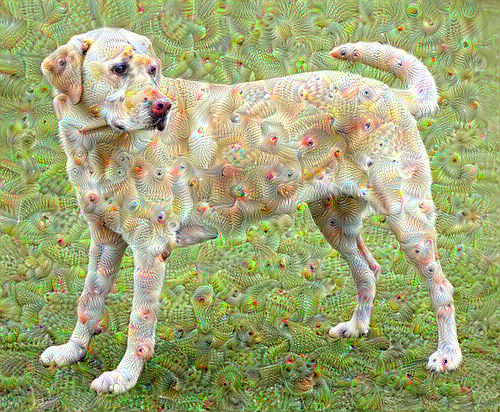

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

### 한 옥타브(octave) 올라가기

- 지금 생성된 이미지도 상당히 인상적이지만, 위의 시도는 몇 가지 문제점들을 가지고 있음

  - 생성된 이미지에 노이즈(noise)가 많이 끼어있음  
    (이 문제는 `tf.image.total_variation loss`로 해결가능).
  
  - 생성된 이미지의 해상도가 낮음

  - 패턴들이 모두 균일한 입도(granularity)로 나타나고 있음


- 위 문제들을 해결할 수 있는 한 가지 방법은 경사상승법의 스케일(scale)를 달리하여 여러 차례 적용
- 이는 작은 스케일에서 생성된 패턴들이 큰 스케일에서 생성된 패턴들에 녹아들어 더 많은 디테일을 형성할 수 있도록 해줌
- 이 작업을 실행하기 위해서는 이전에 구현한 경사상승법을 사용한 후,  
  **이미지의 크기(이를 옥타브라고 부릅니다)를 키우고 여러 옥타브에 대해 이 과정을 반복**

  <img src="https://hackernoon.com/hn-images/1*SFgIqRXLDE03_sUWNnxFzQ.png">

  <sub>[이미지 출처] https://hackernoon.com/dl06-deepdream-with-code-5f735052e21f</sub>
  
  <br>

  <img src="https://drek4537l1klr.cloudfront.net/elgendy/v-7/Figures/Img_09_014.png">

  <sub>[이미지 출처] https://livebook.manning.com/book/grokking-deep-learning-for-computer-vision/chapter-9/v-7/7</sub>

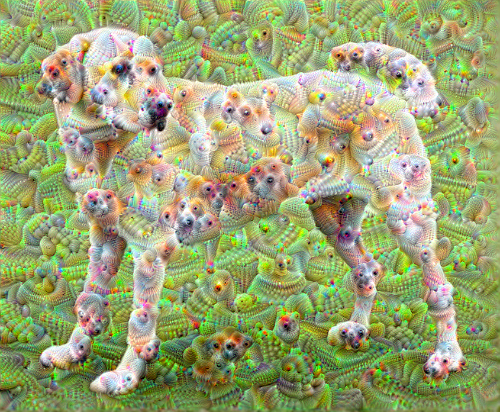

25.76296353340149

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  img = tf.image.resize(img, new_shape).numpy()
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

### 선택 사항 : 타일(tile)을 이용해 이미지 확장

- 한 가지 고려할 사항은 이미지의 크기가 커질수록 그래디언트 계산에 소요되는 시간과 메모리가 늘어난다는 점

- 따라서 위에서 구현한 방식은 옥타브 수가 많거나 입력 이미지의 해상도가 높은 상황에는 적합하지 않음

- 입력 이미지를 여러 타일로 나눠 각 타일에 대해 그래디언트를 계산하면 이 문제를 피할 수 있음

- 각 타일별 그래디언트를 계산하기 전에 이미지를 랜덤하게 이동하면 타일 사이의 이음새가 나타나는 것을 방지할 수 있음

- 이미지를 랜덤하게 이동시키는 작업부터 시작

In [ ]:
def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0], shift[1]
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

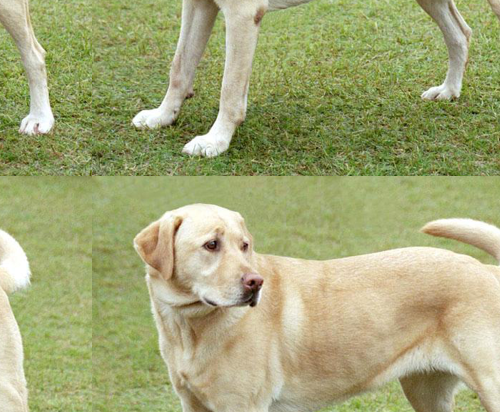

In [ ]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

- deepdreame 함수에 타일 기능 추가

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
                       tf.TensorSpec(shape=[], dtype=tf.int32), )
  )

  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    gradients = tf.zeros_like(img_rolled)

    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        with tf.GradientTape() as tape:
          tape.watch(img_rolled)

          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        gradients = gradients + tape.gradient(loss, img_rolled)

    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

### 옥타브 기반 딥드림 구현

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2, 3), octave_scale=1.3):
  base_shape  = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients * step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print('Octave: {}, Step: {}'.format(octave, step))

  result = deprocess(img)
  return result

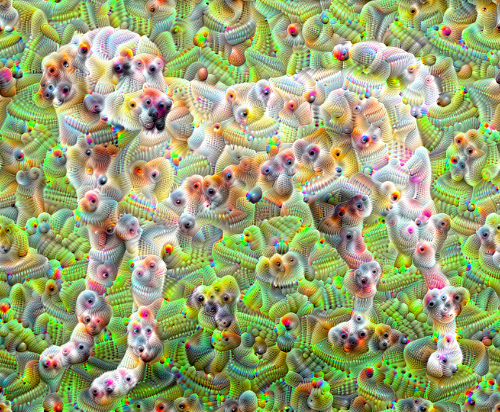

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

### 이미지 선택 2

* https://cphoto.asiae.co.kr/listimglink/6/2019080916322391967_1565335944.jpg

In [ ]:
url2 = 'https://cphoto.asiae.co.kr/listimglink/6/2019080916322391967_1565335944.jpg'

73728/72331 [==============================] - 0s 2us/step


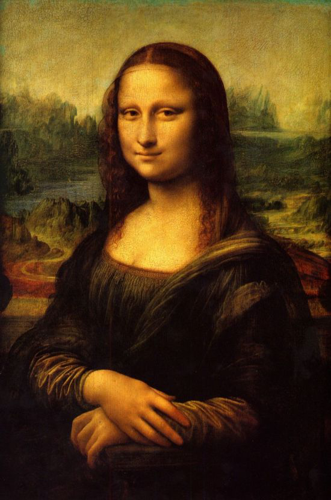

In [ ]:
original_img2 = download(url2, max_dim=500)
show(original_img2)

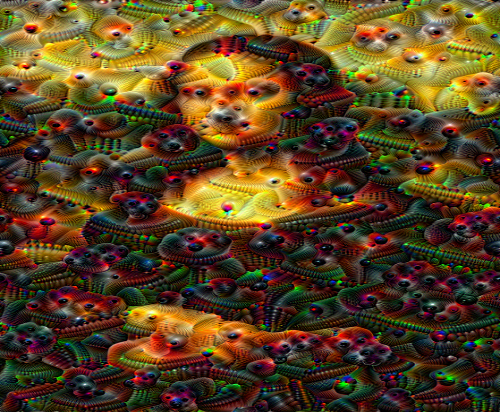

In [ ]:
img = run_deep_dream_with_octaves(img=original_img2, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)